In [1]:
import io
import logging

import numpy as np
import pandas as pd

import skimage.io
import skimage.color

import grequests
import requests

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Conv2D, Dropout, ReLU, LeakyReLU, BatchNormalization, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential

gpus = tf.config.list_physical_devices('GPU')

print(f'Detected gpus: {gpus}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('Set dynamic GPU memory allocation.')

Detected gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Set dynamic GPU memory allocation.


2022-04-14 14:33:12.056764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:33:12.061150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:33:12.061672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
df_train = pd.read_csv("../open_images_v2/train/images.csv", nrows=1000)
print("load train set done.")

df_valid = pd.read_csv("../open_images_v2/validation/images.csv")
print("load validation set done.")

df_test = pd.read_csv("../open_images_v2/test/images.csv")
print("load test set done.")

load train set done.
load validation set done.
load test set done.


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ImageID             1000 non-null   object
 1   Subset              1000 non-null   object
 2   OriginalURL         1000 non-null   object
 3   OriginalLandingURL  1000 non-null   object
 4   License             1000 non-null   object
 5   AuthorProfileURL    1000 non-null   object
 6   Author              1000 non-null   object
 7   Title               1000 non-null   object
 8   OriginalSize        1000 non-null   int64 
 9   OriginalMD5         1000 non-null   object
 10  Thumbnail300KURL    982 non-null    object
dtypes: int64(1), object(10)
memory usage: 86.1+ KB


In [5]:
all(df_train.columns == df_test.columns)

True

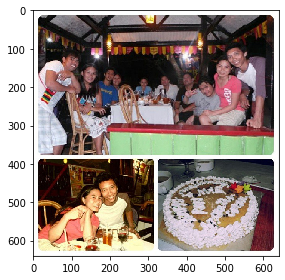

In [6]:
from skimage.io import imread, imshow

img = imread(df_train.iloc[0].OriginalURL)
imshow(img)

In [7]:
from typing import Tuple, List, Iterable, Optional
import PIL


class ImgUrlDataset(tf.keras.utils.Sequence):
    
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int = 32,
        max_width: int = 1080,
        max_height: int = 1080,
    ) -> None:

        expected_cols = {
            "ImageID",
            "OriginalURL",
            "OriginalSize",
            "OriginalMD5",
        }

        assert expected_cols.issubset(set(df.columns)) 

        self.df = df
        self.batch_size = batch_size
        self.max_width = max_width
        self.max_height = max_height


    def __len__(self) -> int:
        return len(self.df) // self.batch_size


    def __getitem__(self, idx: int) -> Tuple[tf.Tensor, tf.Tensor]:
        start = idx * self.batch_size
        end = start + self.batch_size
        rows = self.df.iloc[start:end]
        imgs = self.fetch_imgs(rows.OriginalURL)
        imgs = [self.resize_to_fit(img, self.max_height, self.max_width) for img in imgs]
        imgs = [self.pad_to_size(img, self.max_height, self.width, 0, np.random.default_rng(seed=idx+i)) for i, img in enumerate(imgs)]
        img_bw = [np.expand_dims(skimage.color.rgb2gray(img), -1) for img in imgs]
        x = np.stack(img_bw).astype(np.float32) / 255.0
        y = np.stack(img).astype(np.float32) / 255.0
        # todo normalize to -1/1 range
        # todo return masks
        return tf.convert_to_tensor(x), tf.convert_to_tensor(y)


    @staticmethod
    def resize_to_fit(img: np.ndarray, max_height: int, max_width: int) -> np.ndarray:
        pil_img = PIL.Image.fromarray(img)
        pil_img.thumbnail((max_width, max_height))
        return np.asarray(pil_img)

    @staticmethod
    def pad_to_size(img: np.ndarray, height: int, width: int, bg_val: int, random_gen: np.random.Generator) -> np.ndarray:
        l_padding = random_gen.integers(0, width - img.shape[1] + 1)
        r_padding = width - img.shape[1] - l_padding
        t_padding = random_gen.integers(0, height - img.shape[0] + 1)
        b_padding = height - img.shape[0] - t_padding
        return np.pad(img, [(t_padding, b_padding), (l_padding, r_padding), (0, 0)], constant_values=bg_val)

    @staticmethod
    def response_to_img_safe(response: requests.Response) -> Optional[np.ndarray]:
        try:
            img = skimage.io.imread(io.BytesIO(response.content))
            if len(img.shape) != 3:
                raise ValueError(f"image {response.url} with shape {img.shape} has invalid dimensions.")
            if img.shape[-1] not in (3, 4):
                raise ValueError(f"image {response.url} with shape {img.shape} has wrong number of channels.")
            img = img[:,:,:3] # dropping potential alpha channel
            return img
        except Exception as e:
            logging.warning(response.url, e)
        return None


    @staticmethod
    def fetch_imgs(urls: Iterable[str]) -> List[np.ndarray]:
        reqs = (grequests.get(url, timeout=10) for url in urls)
        responses = grequests.map(reqs)
        imgs = list(map(ImgUrlDataset.response_to_img_safe, responses))
        return [img for img in imgs if img is not None]
        
        


In [8]:
ds_train = ImgUrlDataset(df_train)
ds_valid = ImgUrlDataset(df_valid)
ds_test = ImgUrlDataset(df_test)

In [9]:
def get_unet_generator(
    input_shape: Tuple[Optional[int]] = (None, None, 3),
    encoder_kernel_nums: Tuple[int] = (64, 128, 256, 512, 512, 512, 512, 512),
    decoder_kernel_nums: Optional[Tuple[int]] = None,
    kernel_size: Tuple[int] = (4, 4),
    stride: int = 2,
) -> Model:
    
    if decoder_kernel_nums is None:
        decoder_kernel_nums = encoder_kernel_nums[::-1]

    if len(decoder_kernel_nums) != len(encoder_kernel_nums):
        raise ValueError("number of encoder and decoder layers must match")

    input_layer = Input(shape=input_shape)
    encoder_blocks = []
    decoder_blocks = []
    
    for kernel_num in encoder_kernel_nums:
        if len(encoder_blocks) == 0:
            inputs = input_layer
        else:
            inputs = encoder_blocks[-1]

        block = Sequential([
            Conv2D(kernel_num, kernel_size, padding="same", strides=stride),
            BatchNormalization() if len(encoder_blocks) != 0 else Layer(),
            LeakyReLU(alpha=0.2)
        ])(inputs)

        encoder_blocks.append(block)

    
    for skip_src, kernel_num in zip(encoder_blocks[::-1], decoder_kernel_nums):
        if len(decoder_blocks) == 0:
            inputs = skip_src
        else:
            inputs = Concatenate(axis=3)([skip_src, decoder_blocks[-1]])
                
        block = Sequential([
            Conv2DTranspose(kernel_num, kernel_size, padding="same", strides=2),
            BatchNormalization(),
            Dropout(0.5) if len(decoder_blocks) < 3 else Layer(),
            ReLU(),
        ])(inputs)

        decoder_blocks.append(block)

    output_layer = Conv2DTranspose(3, kernel_size, activation="tanh")(decoder_blocks[-1])
    return Model(inputs=input_layer, outputs=output_layer)

In [10]:
generator = get_unet_generator()

2022-04-14 14:33:13.491525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 14:33:13.491928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:33:13.492530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 14:33:13.493015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, 

In [11]:
# tf.keras.utils.plot_model(generator)

In [12]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 3136        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131712      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 2 525568      sequential_1[0][0]               
______________________________________________________________________________________________

In [13]:
def get_discriminator_block(
    kernel_num: int,
    kernel_size: Tuple[int],
    stride: int,
    batch_norm: bool, 
) -> Sequential:

    return Sequential([
        Conv2D(kernel_num, kernel_size, padding="same", strides=stride),
        BatchNormalization() if batch_norm else Layer(),
        LeakyReLU(alpha=0.2)
    ])


def get_discriminator(
    input_shape: Tuple[Optional[int]] = (None, None, 3),
    kernel_nums: Tuple[int] = (64, 128, 256, 512),
    kernel_size: Tuple[int] = (4, 4),
    stride: int = 2,
) -> Model:

    layers = Sequential()
    layers.add(Input(input_shape))

    for i, kernel_num in enumerate(kernel_nums):
        not_first = i != 0
        block = get_discriminator_block(kernel_num, kernel_size, stride, batch_norm=not_first)
        layers.add(block)

    layers.add(GlobalAveragePooling2D())
    layers.add(Dense(1, activation="sigmoid"))

    return layers


In [14]:
discriminator = get_discriminator()

In [15]:
# tf.keras.utils.plot_model(discriminator, expand_nested=True)

In [16]:
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, None, None, 64)    3136      
_________________________________________________________________
sequential_18 (Sequential)   (None, None, None, 128)   131712    
_________________________________________________________________
sequential_19 (Sequential)   (None, None, None, 256)   525568    
_________________________________________________________________
sequential_20 (Sequential)   (None, None, None, 512)   2099712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 2,760,641
Trainable params: 2,758,849
Non-trainable params: 1,792
_______________________________________